The goal of this competition is to predict monthly microbusiness density in a given area.

Files:
External data sources may be used for county features

train.csv
test.csv
sample_submission.csv
census_starter.csv

#### Importing libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import random

sns.set_context('notebook')

#### Reading datasets

In [35]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
census = pd.read_csv('census_starter.csv')

In [36]:
train.shape

(122265, 7)

In [37]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [38]:
train.dtypes

row_id                    object
cfips                      int64
county                    object
state                     object
first_day_of_month        object
microbusiness_density    float64
active                     int64
dtype: object

row_id is just cfips and date concatenated

In [39]:
train = train.astype({'cfips':'category', 'county':'category', 
    'state':'category', 'first_day_of_month':'datetime64[ns]'})
train.dtypes

row_id                           object
cfips                          category
county                         category
state                          category
first_day_of_month       datetime64[ns]
microbusiness_density           float64
active                            int64
dtype: object

In [40]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [41]:
train.isnull().sum()

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
dtype: int64

In [42]:
train.nunique()

row_id                   122265
cfips                      3135
county                     1871
state                        51
first_day_of_month           39
microbusiness_density     97122
active                    19193
dtype: int64

Counties have duplicate names. Dropping county column. Also, row_id can be dropped.

In [43]:
train.drop(columns = ['row_id', 'county'], inplace = True)

In [44]:
train['first_day_of_month'].min(), train['first_day_of_month'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2022-10-01 00:00:00'))

No missing months overall

In [45]:
39*3135

122265

No missing months for any county

In [46]:
any(train.duplicated(subset=['cfips', 'first_day_of_month']))

False

In [47]:
train['first_day_of_month'].dt.day.value_counts()

1    122265
Name: first_day_of_month, dtype: int64

In [48]:
train.head()

,cfips,state,first_day_of_month,microbusiness_density,active
0,1001,Alabama,2019-08-01,3.007682,1249
1,1001,Alabama,2019-09-01,2.884870,1198
2,1001,Alabama,2019-10-01,3.055843,1269
3,1001,Alabama,2019-11-01,2.993233,1243
4,1001,Alabama,2019-12-01,2.993233,1243


In [49]:
train.dtypes

cfips                          category
state                          category
first_day_of_month       datetime64[ns]
microbusiness_density           float64
active                            int64
dtype: object

In [50]:
train.head()

,cfips,state,first_day_of_month,microbusiness_density,active
0,1001,Alabama,2019-08-01,3.007682,1249
1,1001,Alabama,2019-09-01,2.884870,1198
2,1001,Alabama,2019-10-01,3.055843,1269
3,1001,Alabama,2019-11-01,2.993233,1243
4,1001,Alabama,2019-12-01,2.993233,1243


In [51]:
train.describe()

,microbusiness_density,active
count,122265.000000,1.222650e+05
mean,3.817671,6.442858e+03
std,4.991087,3.304001e+04
min,0.000000,0.000000e+00
25%,1.639344,1.450000e+02
50%,2.586543,4.880000e+02
75%,4.519231,2.124000e+03
max,284.340030,1.167744e+06


In [52]:
train.loc[train['active']>5000].cfips.nunique()

526

There are 526 counties with more than 5000 microbusinesses. Bigger counties are more likely to have a stable trend or seasonality if any

In [53]:
test.dtypes

row_id                object
cfips                  int64
first_day_of_month    object
dtype: object

In [54]:
test = test.astype({'cfips':'category', 'first_day_of_month':'datetime64[ns]'})

In [55]:
test.dtypes

row_id                        object
cfips                       category
first_day_of_month    datetime64[ns]
dtype: object

In [56]:
test.nunique()

row_id                25080
cfips                  3135
first_day_of_month        8
dtype: int64

In [57]:
test['first_day_of_month'].min(), test['first_day_of_month'].max()

(Timestamp('2022-11-01 00:00:00'), Timestamp('2023-06-01 00:00:00'))

In [58]:
8*3135

25080

So we need prediction for the next 8 months for all 3135 counties

#### Looking for trend, seasonality in the data

In [61]:
cfips_list = train.cfips.unique()

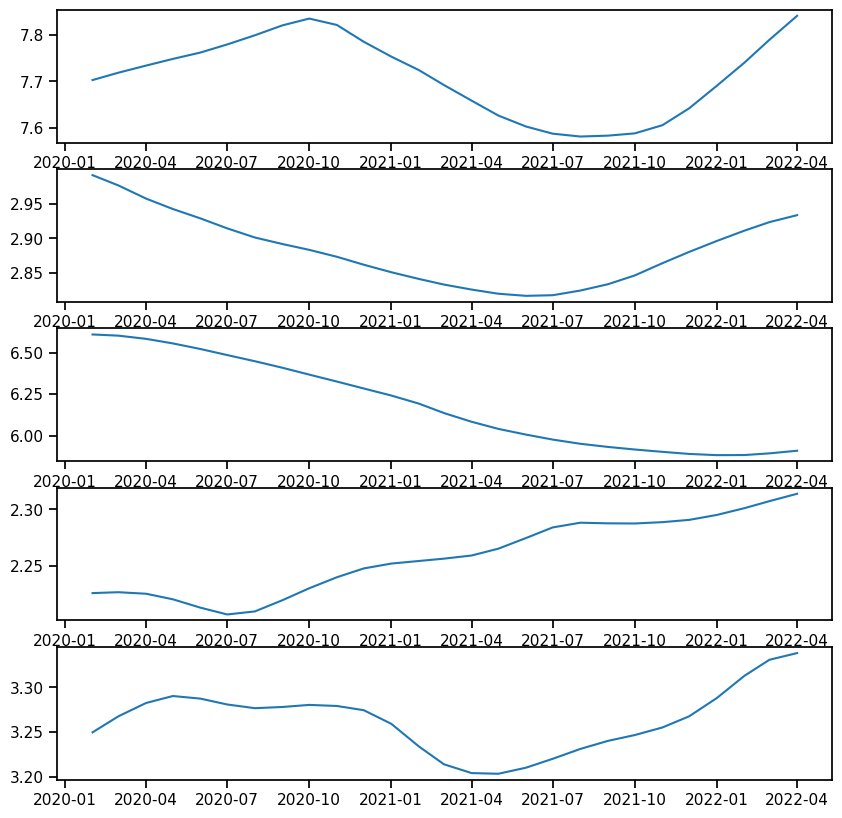

In [79]:
# Looking at random counties
n = 5
fig, axs = plt.subplots(n, figsize = (10,10))

for i in range(n):
    cfips = random.choice(cfips_list)
    temp = train.loc[train['cfips']==cfips, ['first_day_of_month', 'microbusiness_density']]
    temp.set_index('first_day_of_month', inplace = True)
    decom_data = seasonal_decompose(temp['microbusiness_density'])
    axs[i].plot(temp.index, decom_data.trend)

Trend varies a lot

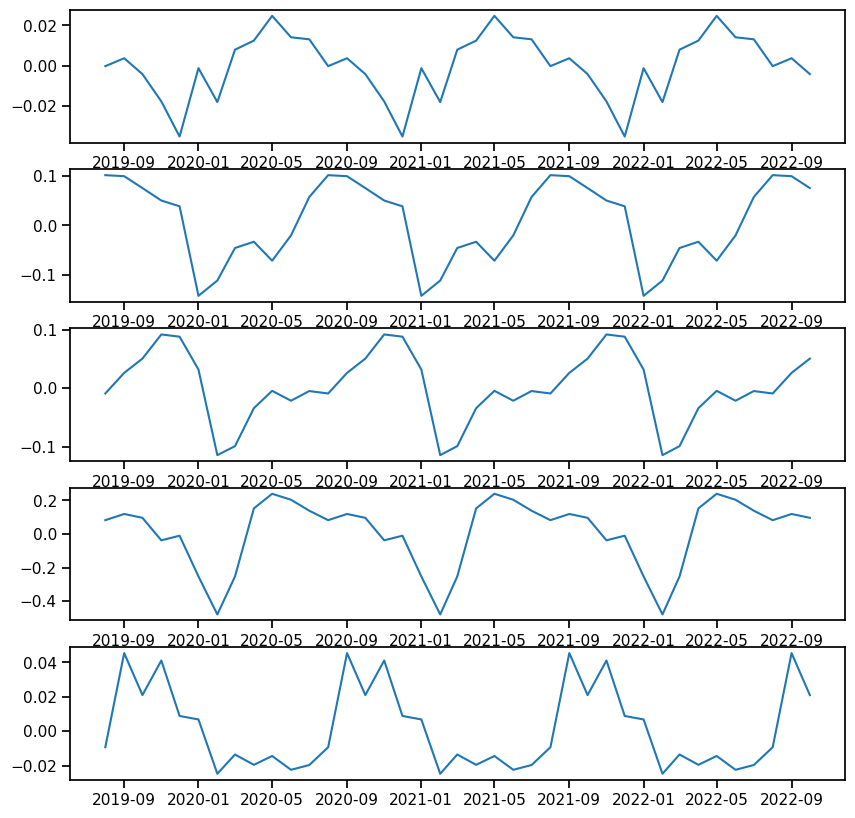

In [80]:
# Looking at random counties for seasonality
n = 5
fig, axs = plt.subplots(n, figsize = (10,10))
for i in range(n):
    cfips = random.choice(cfips_list)
    temp = train.loc[train['cfips'] == cfips, [
        'first_day_of_month', 'microbusiness_density']]
    temp.set_index('first_day_of_month', inplace=True)
    decom_data = seasonal_decompose(temp['microbusiness_density'])
    axs[i].plot(temp.index, decom_data.seasonal)


There seems to be a yearly seasonality

#### Trend for counties within a state

In [83]:
states_list = train.state.unique()

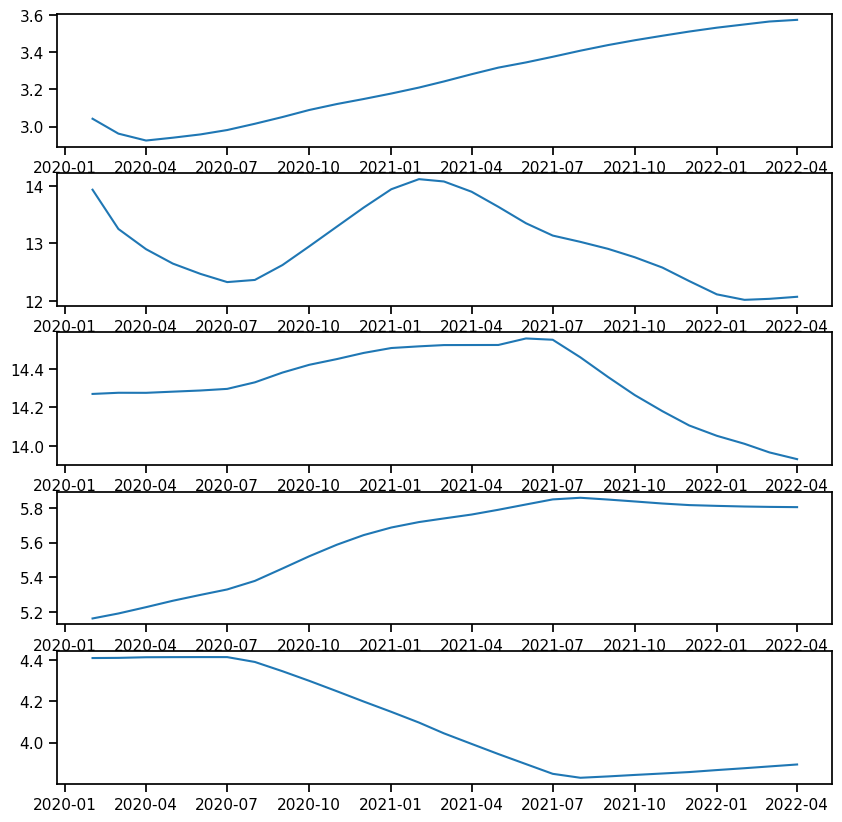

In [87]:
# Looking at random counties within a single state
n = 5
state = random.choice(states_list)
temp = train.loc[train['state']==state]
fig, axs = plt.subplots(n, figsize = (10,10))

for i in range(n):
    cfips = random.choice(temp.cfips.unique())
    temp2 = temp.loc[temp['cfips']==cfips, ['first_day_of_month', 'microbusiness_density']]
    temp2.set_index('first_day_of_month', inplace = True)
    decom_data = seasonal_decompose(temp2['microbusiness_density'])
    axs[i].plot(temp2.index, decom_data.trend)

Trend varies a lot within a state as well

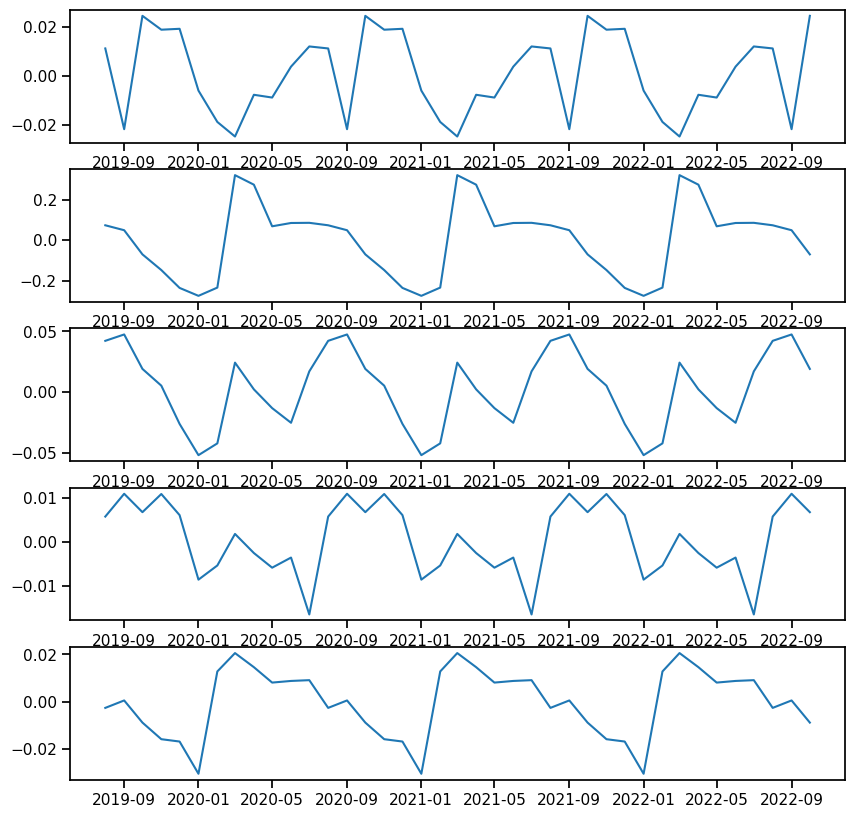

In [88]:
# Looking at random counties within a single state
n = 5
state = random.choice(states_list)
temp = train.loc[train['state'] == state]
fig, axs = plt.subplots(n, figsize=(10, 10))

for i in range(n):
    cfips = random.choice(temp.cfips.unique())
    temp2 = temp.loc[temp['cfips'] == cfips, [
        'first_day_of_month', 'microbusiness_density']]
    temp2.set_index('first_day_of_month', inplace=True)
    decom_data = seasonal_decompose(temp2['microbusiness_density'])
    axs[i].plot(temp2.index, decom_data.seasonal)
